In [1]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
from deeptensor import (
    FeedForwardLayer,
    GeLu,
    LeakyReLu,
    Model,
    ReLu,
    Sigmoid,
    SoftMax,
    Tanh,
    Tensor,
    Value,
)

In [3]:
np.random.seed(1337)
random.seed(1337)

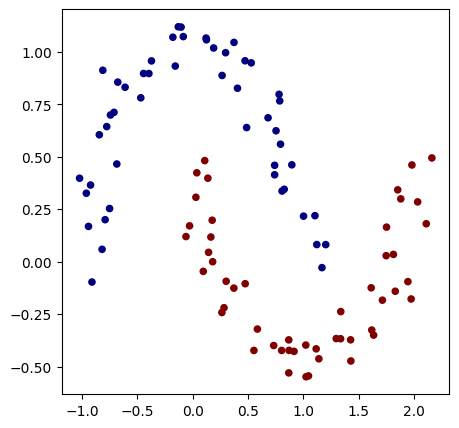

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs

X, y = make_moons(n_samples=100, noise=0.1)

y = y * 2 - 1  # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")

In [5]:
# initialize a model
# model = Model(2, [16, 16, 1])  # 2-layer neural network
model = Model(
    [
        FeedForwardLayer(2, 16),
        FeedForwardLayer(16, 16),
        FeedForwardLayer(16, 1),
    ],
    False,  # using_cuda
)

print(model)

Model(
	Layer(2,16),
	Layer(16,16),
	Layer(16,1),
)


In [6]:
# loss function
def my_loss_fn():
    scores = []
    for x in X:
        inp_tensor = Tensor([2])
        inp_tensor.set(0, Value(x[0]))
        inp_tensor.set(1, Value(x[1]))
        out = model(inp_tensor)
        scores.append(out)

    # svm "max-margin" loss
    losses = [(1 + (-yi * scorei.get(0))).relu() for yi, scorei in zip(y, scores)]

    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum(p * p for p in model.parameters())
    total_loss = data_loss + reg_loss

    # Also get accuracy
    accuracy = [(yi > 0) == (scorei.get(0).data > 0) for yi, scorei in zip(y, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [7]:
# optimization
for k in range(100):
    # forward
    total_loss, acc = my_loss_fn()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 0.001
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.2167291239356866, accuracy 27.0%
step 1 loss 1.2111880673960553, accuracy 27.0%
step 2 loss 1.2056941583134015, accuracy 27.0%
step 3 loss 1.2002460010482119, accuracy 27.0%
step 4 loss 1.1948422205145766, accuracy 27.0%
step 5 loss 1.189481461483697, accuracy 27.0%
step 6 loss 1.1841623879034364, accuracy 27.0%
step 7 loss 1.1788836822332678, accuracy 27.0%
step 8 loss 1.1736440447940382, accuracy 27.0%
step 9 loss 1.1684421931319493, accuracy 27.0%
step 10 loss 1.163276861396211, accuracy 27.0%
step 11 loss 1.1581467997297985, accuracy 27.0%
step 12 loss 1.153050773672798, accuracy 27.0%
step 13 loss 1.1479875635778152, accuracy 27.0%
step 14 loss 1.1429559640369462, accuracy 27.0%
step 15 loss 1.137954783319832, accuracy 27.0%
step 16 loss 1.1329828428223012, accuracy 27.0%
step 17 loss 1.1280389765251684, accuracy 27.0%
step 18 loss 1.1231220304627099, accuracy 27.0%
step 19 loss 1.1182308622003976, accuracy 27.0%
step 20 loss 1.1133643403214508, accuracy 27.0%
step 2

(-1.548639298268643, 1.951360701731357)

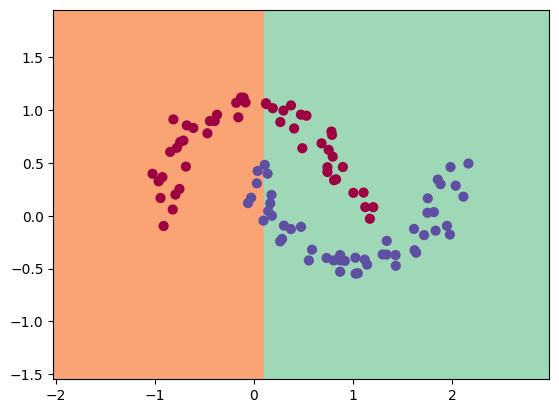

In [8]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]

tensor_input = [Tensor([2]) for _ in range(len(inputs))]
for i in range(len(inputs)):
    tensor_input[i].set(0, inputs[i][0])
    tensor_input[i].set(1, inputs[i][1])

scores = list(map(model, tensor_input))
Z = np.array([s.get(0).data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
